# Homework 4 (due Nov 8)

## Image quantization (40)
#### Brian Stampe

One popular use of the k-means algorithm is in image compression (see Murphy 11.4.2.6).  In general images are encoded as a grid of 3 8-bit integers (the red, green, and blue bands, each ranging from 0-255).  To use K-means to compress an image, K-means clustering is performed on the array of pixel values to obtain the K colors most that in some sense contain the most information.  The compressed image is generated by replacing each pixel value with the index of the nearest K-means cluster center.  When it is time to display the image, each pixel value is reconstructed by looking up the RGB value corresponding to its index.  This process is referred to as *Image quantization*.

Import an image of your choosing, and apply K-means based image quantization to it.  You can write the code for K-means yourself, adapt the code from the lecture, or you can use the scikit-learn implementation, which can be imported with the following command:

In [1]:
from sklearn.cluster import KMeans  # Useful for doing K-means clustering
from matplotlib.pyplot import imread    # Useful for reading image files
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc

**Use $k=2^3=8$ clusters**.  Display both the original image and the quantized version.  

In [2]:
pic = imread('Glacier.jpg')
row, col = len(pic[:,0,0]),len(pic[0,:,0]) # row is length of the rows in original image
pic = np.reshape(pic, (row*col,3)) # reshape into an easier shape
n_clusters = 8
kmeans = KMeans(n_clusters)
kmeans.fit(pic)
centroids = np.array(kmeans.cluster_centers_,dtype=np.uint8) # 2^8 or 256 possible states now, reduces size and rounds!
labels = np.array(kmeans.labels_,dtype=np.uint8)
labels = labels.reshape(row, col)

#np.save('centroids.npy',centroids)    
#scipy.misc.toimage(labels, cmin=0.0,cmax=n_clusters).save('compressed.jpg')

Text(0.5,1,'Original image')

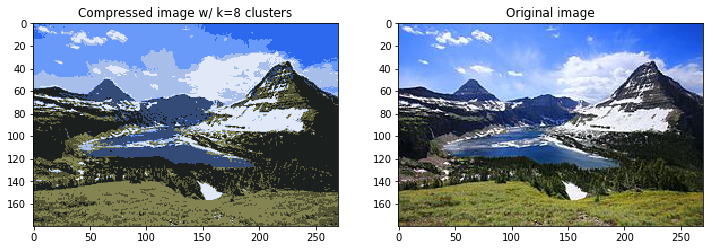

In [3]:
#compressed_pic = imread('compressed.jpg')
#centroids = np.load('centroids.npy')

new_image = np.zeros([row,col,3])
count = 0
other_count = 0
for i in range(row):
    count += 1
    for j in range(col):
        other_count +=1
        new_image[i,j,:] = centroids[labels[i,j],:]


fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(180./15,270./15))
new_image = new_image.astype(int) # change to int so basic imshow doesn't clip thinking its float      
ax1.imshow(new_image)
ax1.set_title('Compressed image w/ k=8 clusters')
pic = imread('Glacier.jpg')
ax2.imshow(pic)
ax2.set_title('Original image')
#from IPython.display import Image
#Image(filename='Glacier.jpg')

#### actual compression = (original image - (compressed.jpg + codebook.npy) )/ original image =  13.5kB/16kB = 

##### 84% or 6.5 compression factor

###### Theoretical Compression: see Moodle handin.

**Please submit answers to the following questions to Assignment 4 on Moodle.**
1. Is the above compression technique "lossy", i.e. could you recover the original image from the compressed one?
2. (Grad students only) In theory, how much storage savings is achieved using this type of compression compared to an 8-bit, 3-channel uncompressed image? 

## Linear Regression

<img src="cricket.jpg" width=30%>
For centuries, it's been understood that the frequency of cricket chirps increases as temperature increases.  In this problem, you will determine the functional relationship between these two variables such that cricket chirps can be used as a thermometer. 

To begin, import the data file cricket.txt.  The first column is the temperature in degrees C, while the second column is the number of cricket chirps per 15 seconds.  Using scikit-learn's model selection tools, we can split the data into a training set, which will be used to train the model, and a test set, which will be used to validate the model's performance on data that was *not* used to train it.  

In [4]:
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt('crickets.txt')

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data[:,0], data[:,1], test_size=0.5, random_state=42)

### 1. Ordinary Least Squares (20)
Your first task is to define a function that will fit a polynomial of arbitrary degree to the data, subject to Tikhonov regularization.  To do this you will have to generate the Vandermonde matrix $X$, and solve the normal equations 
$$
(X^T X + \gamma \mathcal{I}) \mathbf{w} = X^T y,
$$
where $\mathbf{w}$ is the vector of polynomial coefficients.  Plot the data with the optimal polynomial of degree 1 (a line) overlain. 

In [5]:
def fit_polynomial(X,y,d,gamma=0):
    """  Find the ordinary least squares fit of an independent 
        variable X to a dependent variable y"""
    X_vander = np.vander(X,d+1,increasing = True)
    I = np.eye(d+1)
    W = np.linalg.solve((X_vander.T @ X_vander)+gamma*I,(X_vander.T @ y)) # add gamma I later 
    y_pred = X_vander@W  
    return W, y_pred

fit_polynomial(X_train, y_train, d=1)



(array([4.66639585, 0.49047766]),
 array([20.06739449, 19.13548693, 22.81406941, 26.24741305, 11.53308314,
        22.42168728, 20.90120652, 17.46786287, 27.42455945, 18.76762868,
        26.05122199, 18.25262714, 20.01834672, 22.86311717, 20.55787215,
        13.24975496, 10.79736665, 16.19262095, 18.8902481 , 10.79736665,
        19.87120343, 18.25262714, 16.27109737, 22.42168728, 21.83311408,
        17.41881511, 19.47882129]))

Text(0.5,1,'Wow--is this real data?')

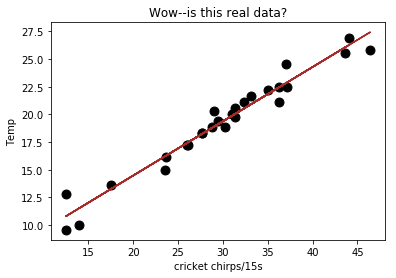

In [6]:

plt.scatter(X_train, y_train, s=80, c='black')
plt.plot(X_train, fit_polynomial(X_train, y_train, d=1)[1], c='brown')
plt.xlabel('cricket chirps/15s')
plt.ylabel('Temp')
plt.title('Wow--is this real data?')


### 2. Overfitting (20)
With the above function in hand, now we will explore the effect of fitting higher degree polynomials to the data.  Fit the training data using polynomials from degree 1 to 15, without regularization (i.e. $\gamma=0$).  For each of these fits, record the resulting root mean square error in both the training and test data.  Plot both of these RMSE values as a function of polynomial degree (Using a logarithmic scale for RMSE is helpful).  **In a document that you submit to Assignment 4 on Moodle, describe the pattern that you see, and explain the reason behind the different behavior between the two curves.**  

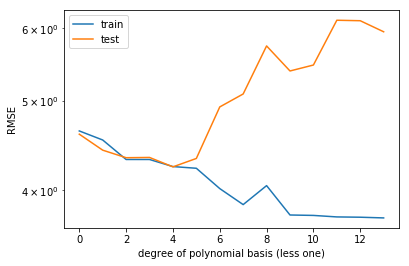

In [7]:
train_rmse = []
test_rmse = []
for d in range(1,15):
    # Use the function you generated above to fit a polynomial of degree d to the cricket data
    
    # Report the RMSE 
    X_vander_train = np.vander(X_train,d+1,increasing = True)
    X_vander_test = np.vander(X_test,d+1,increasing = True)   
    
    W = fit_polynomial(X_train,y_train,d)[0]

    train_rmse.append(np.sqrt(np.sum(((X_vander_train @ W) - y_train)**2)))
    test_rmse.append(np.sqrt(np.sum(((X_vander_test @ W) - y_test)**2)))

plt.semilogy(train_rmse, label='train')
plt.semilogy(test_rmse, label='test')
plt.xlabel('degree of polynomial basis (less one)')
plt.ylabel('RMSE')
plt.legend()
plt.show()

### 3. Regularization(*) (20)
Fix the polynomial degree at 9, and now fit the training data for regularization parameter $\gamma \in [10^{-9},10^2]$ (you'll want to distribute these points in log-space; see below).  As above compute the RMSE in the training and test sets, and plot as a function of $\gamma$.  **In a document that you submit to Assignment 4 on Moodle, describe the pattern that you see, and explain the reason behind the different behavior between the two curves.**  

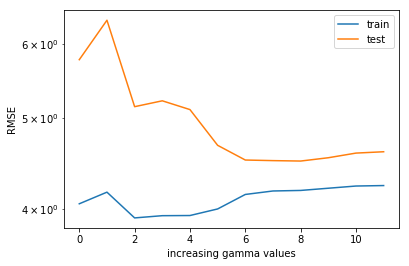

In [8]:
train_rmse = []
test_rmse = []
gammas = np.logspace(-9,2,12)
d = 9

for gamma in gammas:
    # Use the function you generated above to fit a polynomial of degree d to the cricket data
    
    # Report the RMSE 
    X_vander_train = np.vander(X_train,d+1,increasing = True)
    X_vander_test = np.vander(X_test,d+1,increasing = True)    
    
    W = fit_polynomial(X_train,y_train,d,gamma=gamma)[0]

    train_rmse.append(np.sqrt(np.sum((np.dot(X_vander_train,W) - y_train)**2)))
    test_rmse.append(np.sqrt(np.sum((np.dot(X_vander_test,W) - y_test)**2)))

plt.semilogy(train_rmse, label='train')
plt.semilogy(test_rmse, label='test')
plt.xlabel('increasing gamma values')
plt.ylabel('RMSE')
plt.legend()
plt.show()